# Modeling with PSO-GA feature selection (next year)

## Install packages

In [1]:
# Set current working directory
import os
path = "/Users/fleurroijen/Library/Mobile Documents/com~apple~CloudDocs/Documents/University/Tilburg University MSc/TiU Spring 24:25/Master Thesis : Data Science in Action/Predicting-Tax-Avoidance"
os.chdir(path)

In [2]:
# Loading necessary packages
import datetime
import warnings
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

# Visualization
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from pandas.plotting import register_matplotlib_converters

# Optimization
import optuna
from optuna import Trial, visualization

# Scikit-learn
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score
)

# XGBoost
from xgboost import XGBClassifier

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Loading the datasets
X_train_full = pd.read_csv('X_train_full.csv', index_col=0)
X_train = pd.read_csv('X_train.csv', index_col=0)
X_val = pd.read_csv('X_val.csv', index_col=0)
X_test = pd.read_csv('X_test.csv', index_col=0)
y_train_full = pd.read_csv('y_train_full.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
y_val = pd.read_csv('y_val.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

In [4]:
# Checking the datasets
print(X_train_full.shape)
print(y_train_full.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(43522, 77)
(43522, 1)
(34818, 77)
(34818, 1)
(8704, 77)
(8704, 1)
(7445, 77)
(7445, 1)


In [5]:
if isinstance(y_train_full, pd.DataFrame) and y_train_full.shape[1] == 1:
    y_train_full = y_train_full.squeeze()

In [6]:
if isinstance(y_train, pd.DataFrame) and y_train.shape[1] == 1:
    y_train = y_train.squeeze()
y_train = np.asarray(y_train)

In [7]:
if not isinstance(y_train_full, pd.Series):
    y_train_full = pd.Series(y_train_full, name="tax_avoidance_ind")

In [8]:
if not isinstance(y_train, pd.Series):
    y_train = pd.Series(y_train, name="tax_avoidance_ind")

## Feature selection with PSO-GA

In [9]:
# Code inspired by:
# https://github.com/izzuddinafif/MATLAB-GA-PSO/blob/master/src/main_script.m

In [10]:
# Evaluating fitness
def evaluate_fitness(genes, X_train, X_val, y_train, y_val):
    selected_features = np.where(genes == 1)[0]
    if len(selected_features) == 0:
        return 0
    X_train_selected = X_train.iloc[:, selected_features]
    X_val_selected = X_val.iloc[:, selected_features]
    clf = RandomForestClassifier()
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_val_selected)
    f1 = f1_score(y_val, y_pred)
    return f1

In [11]:
# Function to evaluate individual fitness in parallel
def evaluate_individual(i, population, X_train, X_val, y_train, y_val):
    genes = population[i, :-1]
    fitness_i = evaluate_fitness(genes, X_train, X_val, y_train, y_val)
    return fitness_i

In [12]:
# Enforcing the constraint that if fyear_sin is selected, fyear_cos must be selected (and vice versa)
def enforce_feature_constraint(genes, fyear_sin_index, fyear_cos_index):
    if genes[fyear_sin_index] == 1:
        genes[fyear_cos_index] = 1
    if genes[fyear_cos_index] == 1:
        genes[fyear_sin_index] = 1
    return genes

In [13]:
# Initalizing population for GA
def init_population(pop_size, num_features, min_features, max_features, fyear_sin_index, fyear_cos_index):
    population = np.zeros((pop_size, num_features + 1))
    for i in range(pop_size):
        genes = np.random.rand(num_features) > 0.5
        genes = enforce_feature_constraint(genes, fyear_sin_index, fyear_cos_index)
        num_selected = np.sum(genes)
        while num_selected < min_features or num_selected > max_features:
            genes = np.random.rand(num_features) > 0.5
            genes = enforce_feature_constraint(genes, fyear_sin_index, fyear_cos_index)
            num_selected = np.sum(genes)
        fitness = evaluate_fitness(genes, X_train, X_val, y_train, y_val)
        population[i, :] = np.concatenate([genes, [fitness]])
    return population

In [14]:
# Initializing particles for PSO
def init_pso(population, num_features):
    particles = {
        'position': population[:, :-1],
        'velocity': np.zeros_like(population[:, :-1]),
        'personal_best_position': population[:, :-1],
        'personal_best_fitness': population[:, -1]
    }
    return particles

In [15]:
# Selecting parents for GA using roulette wheel selection
def select_roulette_wheel(population, pop_size):
    fitness = population[:, -1]
    total_fitness = np.sum(fitness)
    probabilities = fitness / total_fitness
    r = np.random.rand()
    cumulative = 0
    for i in range(pop_size):
        cumulative += probabilities[i]
        if r <= cumulative:
            return population[i, :]
    return population[-1, :]

In [16]:
# Crossover operation for GA
def crossover(parent, population, crossover_prob, num_features, fyear_sin_index, fyear_cos_index):
    if np.random.rand() < crossover_prob:
        partner = select_roulette_wheel(population, population.shape[0])
        crossover_point = np.random.randint(1, num_features)
        offspring = np.concatenate([parent[:crossover_point], partner[crossover_point:num_features]])
    else:
        offspring = parent[:num_features]
    offspring = enforce_feature_constraint(offspring, fyear_sin_index, fyear_cos_index)
    return offspring

In [17]:
# Enforcing feature bounds
def enforce_feature_bounds(binary_vector, min_features, max_features):
    selected = np.where(binary_vector == 1)[0]
    if len(selected) > max_features:
        turn_off = np.random.choice(selected, len(selected) - max_features, replace=False)
        binary_vector[turn_off] = 0
    elif len(selected) < min_features:
        unselected = np.where(binary_vector == 0)[0]
        turn_on = np.random.choice(unselected, min_features - len(selected), replace=False)
        binary_vector[turn_on] = 1
    return binary_vector

In [18]:
# Mutating genes for GA
def mutate(offspring, mutation_prob, num_features, fyear_sin_index, fyear_cos_index):
    if np.random.rand() < mutation_prob:
        mutation_point = np.random.randint(num_features)
        offspring[mutation_point] = 1 - offspring[mutation_point]
    offspring = enforce_feature_constraint(offspring, fyear_sin_index, fyear_cos_index)
    return offspring

In [19]:
# Updating the velcoity and positions of particles for PSO
def update_pso(particles, inertia_weight, cognitive_coeff, social_coeff, gbest_position, fyear_sin_index, fyear_cos_index):
    r1 = np.random.rand(*particles['position'].shape)
    r2 = np.random.rand(*particles['position'].shape)
    particles['velocity'] = (inertia_weight * particles['velocity'] +
                             cognitive_coeff * r1 * (particles['personal_best_position'] - particles['position']) +
                             social_coeff * r2 * (gbest_position - particles['position']))
    particles['position'] = particles['position'] + particles['velocity']
    particles['position'] = np.clip(particles['position'], 0, 1)
    
    # Enforce feature constraint in PSO position update
    for i in range(particles['position'].shape[0]):
        particles['position'][i, :] = enforce_feature_constraint(particles['position'][i, :], fyear_sin_index, fyear_cos_index)
    
    return particles

In [20]:
# Evaluating PSO fitness
def evaluate_pso_fitness(particles, X_train, X_val, y_train, y_val):
    fitness = np.zeros(particles['position'].shape[0])
    for i in range(particles['position'].shape[0]):
        genes = particles['position'][i, :]
        fitness[i] = evaluate_fitness(genes, X_train, X_val, y_train, y_val)
    return fitness

In [21]:
# Setting hyperparameters
min_features = 2
max_features = 37
pop_size = 20
max_iterations = 20
crossover_prob = 0.8
mutation_prob = 0.3
inertia_weight = 0.7
cognitive_coeff = 1.5
social_coeff = 1.5

num_features = X_train.shape[1]
feature_names = X_train.columns
fyear_sin_index = feature_names.get_loc('fyear_sin')  # Get index of 'fyear_sin'
fyear_cos_index = feature_names.get_loc('fyear_cos')  # Get index of 'fyear_cos'
early_stopping_rounds = 10

In [ ]:
# Starting the main optimization loop
population = init_population(pop_size, num_features, min_features, max_features, fyear_sin_index, fyear_cos_index)
particles = init_pso(population, num_features)

# Initializing global best (gbest) for PSO
gbest_fitness = np.max(particles['personal_best_fitness'])
gbest_position = particles['personal_best_position'][np.argmax(particles['personal_best_fitness'])]

# Storing best fitness value at each iteration for early stopping
best_fitness = np.zeros(max_iterations)

# Main optimization loop
no_improvement_count = 0
best_overall_fitness = gbest_fitness
for iter in range(max_iterations):
    print(f'Begin iteration num {iter + 1}/{max_iterations}')
    iter += 1

    # Genetic Algorithm operations
    new_population = np.zeros_like(population)
    fitness = Parallel(n_jobs=-1)(delayed(evaluate_individual)(i, population, X_train, X_val, y_train, y_val) for i in range(pop_size))
    fitness = np.array(fitness)
    offsprings = []
    for i in range(pop_size):
        parent = select_roulette_wheel(population, pop_size)
        offspring = crossover(parent, population, crossover_prob, num_features, fyear_sin_index, fyear_cos_index)
        offspring = mutate(offspring, mutation_prob, num_features, fyear_sin_index, fyear_cos_index)
        offsprings.append(offspring)
    fitness = Parallel(n_jobs=-1)(
        delayed(evaluate_fitness)(offspring, X_train, X_val, y_train, y_val)
        for offspring in offsprings
    )
    for i in range(pop_size):
        new_population[i, :] = np.concatenate([offsprings[i], [fitness[i]]])
    population = new_population

    # PSO operations
    fitness = population[:, -1]
    for i in range(pop_size):
        genes = population[i, :-1]
        if fitness[i] > particles['personal_best_fitness'][i]:
            particles['personal_best_position'][i, :] = genes
            particles['personal_best_fitness'][i] = fitness[i]
            if fitness[i] > gbest_fitness:
                gbest_fitness = fitness[i]
                gbest_position = genes

    # Updating particles' velocities and positions using PSO formulas
    particles = update_pso(particles, inertia_weight, cognitive_coeff, social_coeff, gbest_position, fyear_sin_index, fyear_cos_index)

    # Evaluating fitness for updated particles
    particles_fitness = evaluate_pso_fitness(particles, X_train, X_val, y_train, y_val)
    particles['personal_best_fitness'] = np.maximum(particles['personal_best_fitness'], particles_fitness)

    # Tracking best fitness
    best_fitness[iter] = gbest_fitness

    # Early stopping logic (explicit no improvement counter)
    if gbest_fitness > best_overall_fitness:
        best_overall_fitness = gbest_fitness
        no_improvement_count = 0
    else:
        no_improvement_count += 1
        print(f"No improvement for {no_improvement_count} generations.")

    if no_improvement_count >= early_stopping_rounds:
        print(f"Early stopping triggered at iteration {iter + 1}.")
        break

    # Output progress
    if iter % 100 == 0 or iter == 1:
        print(f'Iteration {iter}/{max_iterations}, Best fitness: {gbest_fitness}')

# Final result
print(f'Best fitness achieved: {gbest_fitness}')
print(f'Best feature set: {np.where(gbest_position == 1)[0]}')

Begin iteration num 1/20


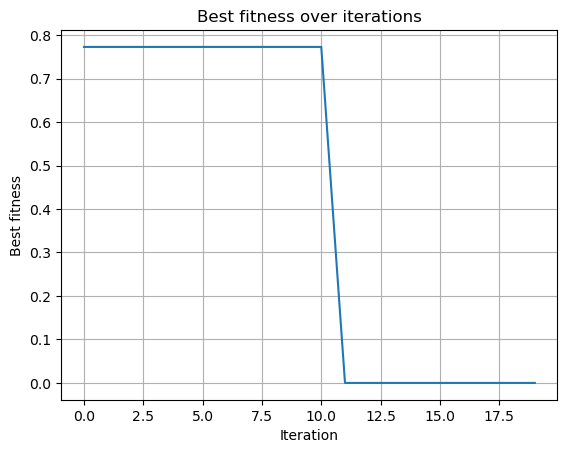

In [ ]:
# Plotting results
plt.plot(best_fitness)
plt.xlabel("Iteration")
plt.ylabel("Best fitness")
plt.title("Best fitness over iterations")
plt.grid()
plt.show()

In [ ]:
best_feature_indices = np.where(gbest_position == 1)[0]
best_feature_names = X_train_full.columns[best_feature_indices]

# Create the new datasets with the selected features
X_train_PSO_GA_full = X_train_full.iloc[:, best_feature_indices]
X_train_PSO_GA = X_train.iloc[:, best_feature_indices]
X_val_PSO_GA = X_val.iloc[:, best_feature_indices]
X_test_PSO_GA = X_test.iloc[:, best_feature_indices]

# Summarize the results
print("Selected features from PSO-GA:", list(best_feature_names))
print("Shape of reduced full training data (X_train_PSO_GA_full):", X_train_PSO_GA_full.shape)
print("Shape of reduced training data (X_train_PSO_GA):", X_train_PSO_GA.shape)
print("Shape of reduced validation data (X_val_PSO_GA):", X_val_PSO_GA.shape)
print("Shape of reduced test data (X_test_PSO_GA):", X_test_PSO_GA.shape)

Selected features from PSO-GA: ['act_lag1', 'apo_lag1', 'capx_lag1', 'ceq_lag1', 'dc_lag1', 'dlc_lag1', 'ebit_lag1', 'ib_lag1', 'icapt_lag1', 'oancf_lag1', 'oiadp_lag1', 'oibdp_lag1', 'ppegt_lag1', 'pstk_lag1', 'recco_lag1', 'txc_lag1', 'txdi_lag1', 'txditc_lag1', 'txo_lag1', 'txp_lag1', 'txt_lag1', 'wcap_lag1', 'xint_lag1', 'etr_lag1', 'industry_Information', 'industry_Services', 'industry_Social', 'fyear_sin']
Shape of reduced full training data (X_train_PSO_GA_full): (43522, 28)
Shape of reduced training data (X_train_PSO_GA): (34818, 28)
Shape of reduced validation data (X_val_PSO_GA): (8704, 28)
Shape of reduced test data (X_test_PSO_GA): (7445, 28)


## Modeling

### Baseline logistic regression (no hyperparameter tuning)

In [ ]:
# Instantiating the classifier 
model_lr = LogisticRegression(random_state=123)

# Fitting the model
model_lr.fit(X_train_PSO_GA_full, y_train_full)

LogisticRegression(random_state=123)

In [ ]:
# Making predictions (test set)
y_pred_lr = model_lr.predict(X_test_PSO_GA)
y_proba_lr = model_lr.predict_proba(X_test_PSO_GA)
y_proba_lr_pos = y_proba_lr[:, 1]

In [ ]:
# Making predictions (train set)
y_pred_lr_train = model_lr.predict(X_train_PSO_GA_full)
y_proba_lr_train = model_lr.predict_proba(X_train_PSO_GA_full)
y_proba_lr_train_pos = y_proba_lr_train[:, 1]

#### Evaluating baseline logistic regression

In [ ]:
# Creating a function for the evaluation metrics
def evaluate(y_true, y_pred, y_proba, classifier):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)

    print(f"Evaluation metrics for {classifier}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"Precision-Recall AUC: {pr_auc:.4f}")

In [ ]:
# Evaluating the prediction performance (test set)
evaluate(y_test, y_pred_lr, y_proba_lr_pos, "baseline logistic regression PSO-GA feature selection")

Evaluation metrics for baseline logistic regression PSO-GA feature selection:
Accuracy: 0.6238
Precision: 0.3999
Recall: 0.7935
F1 Score: 0.5318
AUC-ROC: 0.7368
Precision-Recall AUC: 0.4653


In [ ]:
# Evaluating the prediction performance (train set)
evaluate(y_train_full, y_pred_lr_train, y_proba_lr_train_pos, "baseline logistic regression with PSO-GA feature selection (train set)")

Evaluation metrics for baseline logistic regression with PSO-GA feature selection (train set):
Accuracy: 0.6796
Precision: 0.6491
Recall: 0.7818
F1 Score: 0.7093
AUC-ROC: 0.7309
Precision-Recall AUC: 0.6841


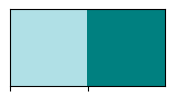

In [ ]:
# Defining a smooth fading color gradient
color_codes = ["powderblue", "teal"]
fading_cmap = LinearSegmentedColormap.from_list("fading_blues", color_codes)

# Displaying the fading color palette (optional)
sns.palplot(sns.color_palette(color_codes))

In [ ]:
# Code inspired by:
# https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
def plot_confusion_matrix(y_true, y_pred, model_name):
    class_names = ['yes', 'no']

    # Computing and normalizing the confusion matrix
    matrix = confusion_matrix(y_true, y_pred)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(matrix, annot=True, fmt=".2f", cmap=fading_cmap, 
                     xticklabels=class_names, yticklabels=class_names,
                     linewidths=0.2, vmin=0, vmax=1)

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.tight_layout()
    plt.show()

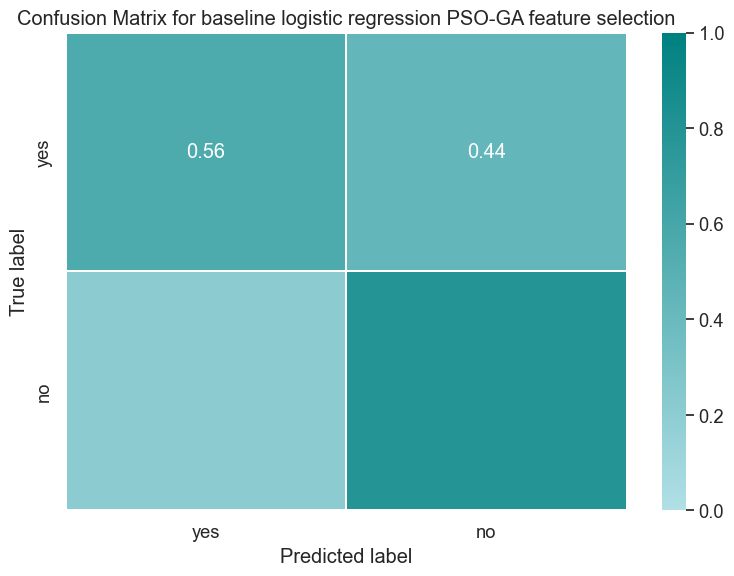

In [ ]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, y_pred_lr, "baseline logistic regression PSO-GA feature selection")

In [ ]:
# Printing the classification report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.88      0.56      0.69      5440
           1       0.40      0.79      0.53      2005

    accuracy                           0.62      7445
   macro avg       0.64      0.68      0.61      7445
weighted avg       0.75      0.62      0.64      7445



### Logistic regression

In [ ]:
# Code inspired by:
# https://stackoverflow.com/questions/55591063/how-to-perform-smote-with-cross-validation-in-sklearn-in-python
# https://github.com/optuna/optuna
# https://medium.com/@taeefnajib/hyperparameter-tuning-using-optuna-c46d7b29a3e
# https://medium.com/@moussadoumbia_90919/mastering-hyperparameter-optimization-with-optuna-a-comprehensive-guide-0bd6b4b1bc67

# Defining an objective function to be maximized using pre-defined train/val splits
def objective_lr(trial):
    # Define all valid (solver, penalty) combos explicitly
    solver_penalty_combo = trial.suggest_categorical(
        'solver_penalty',
        [
            ('lbfgs', 'l2'),               # lbfgs only supports l2
            ('liblinear', 'l1'),
            ('liblinear', 'l2'),
            ('saga', 'l1'),
            ('saga', 'l2'),
            ('saga', 'elasticnet'),
        ]
    )
    
    solver, penalty = solver_penalty_combo
    
    C = trial.suggest_float("C", 1e-4, 1e4, log=True)
    tol = trial.suggest_float("tol", 1e-4, 1e-1, log=True)
    verbose = trial.suggest_int("verbose", 0, 1)
    
    params_lr = dict(solver=solver, penalty=penalty, C=C, tol=tol, verbose=verbose)
    
    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        params_lr["l1_ratio"] = l1_ratio
    
    model_lr = LogisticRegression(**params_lr, random_state=123, n_jobs=-1)
    
    model_lr.fit(X_train_PSO_GA, y_train)
    
    y_pred = model_lr.predict(X_val_PSO_GA)
    f1 = f1_score(y_val, y_pred, average='binary')
    
    return float(f1)

# Running Optuna study
optuna.logging.set_verbosity(optuna.logging.DEBUG)
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=100, n_jobs=-1, timeout=600)

# Printing results
print('Number of finished trials:', len(study_lr.trials))
print('Best parameters:', study_lr.best_trial.params)
print('Best F1 score:', study_lr.best_value)

[I 2025-05-16 21:23:51,355] A new study created in memory with name: no-name-c410dd62-cab6-4570-8490-c4978f2bc54c
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('saga', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna

[LibLinear]iter  1 act 2.881e+05 pre 2.500e+05 delta 7.927e-01 f 2.947e+06 |g| 1.217e+06 CG   4
iter  1 act 1.514e+05 pre 1.313e+05 delta 7.927e-01 f 1.548e+06 |g| 6.394e+05 CG   4
iter  2 act 4.535e+04 pre 4.178e+04 delta 7.927e-01 f 2.659e+06 |g| 2.157e+05 CG   6
iter  2 act 2.382e+04 pre 2.195e+04 delta 7.927e-01 f 1.397e+06 |g| 1.133e+05 CG   6
iter  3 act 7.818e+03 pre 7.061e+03 delta 7.927e-01 f 2.614e+06 |g| 4.702e+04 CG  11
iter  3 act 4.107e+03 pre 3.709e+03 delta 7.927e-01 f 1.373e+06 |g| 2.470e+04 CG  11
Epoch 1, change: 1
Epoch 1, change: 1
iter  4 act 3.234e+02 pre 3.058e+02 delta 7.927e-01 f 1.369e+06 |g| 7.501e+03 CG  10
iter  4 act 6.156e+02 pre 5.822e+02 delta 7.927e-01 f 2.606e+06 |g| 1.428e+04 CG  10
Epoch 2, change: 0.42823426
Epoch 2, change: 0.42491282
Epoch 3, change: 0.26874223
Epoch 3, change: 0.27175298
cg reaches trust region boundary
iter  5 act 5.158e+01 pre 5.087e+01 delta 8.281e-01 f 1.369e+06 |g| 7.419e+02 CG  20
Epoch 4, change: 0.20396032
Epoch 4, chan

 This problem is unconstrained.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/dist

Epoch 7, change: 0.12060889
Epoch 7, change: 0.11966829
Epoch 8, change: 0.10598759
Epoch 8, change: 0.10669235
Epoch 9, change: 0.095059272
Epoch 9, change: 0.095581363
Epoch 10, change: 0.086075585
Epoch 10, change: 0.086472092
Epoch 11, change: 0.078592794
Epoch 11, change: 0.07888802


[I 2025-05-16 21:23:52,167] Trial 9 finished with value: 0.7169034383364217 and parameters: {'solver_penalty': ('liblinear', 'l2'), 'C': 8247.670704760778, 'tol': 0.001540881025407254, 'verbose': 0}. Best is trial 7 with value: 0.7174629324546952.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
[I 2025-05-16 21:23:52,308] Trial 1 finished with value: 0.6755308592974797 and parameters: {'solver_penalty': ('saga', 'l1'), 'C': 0.10191127022617448, 'tol': 0.07184198547366574, 'verbose': 1}. Best is trial 7 with value: 0.7174629324546952.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, i

Epoch 12, change: 0.072522023
Epoch 12, change: 0.072302728
convergence after 13 epochs took 1 seconds
Epoch 13, change: 0.066869926


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 14, change: 0.062177923
Epoch 1, change: 1
Epoch 2, change: 0.42832623
Epoch 3, change: 0.27183597
Epoch 15, change: 0.058081968
Epoch 4, change: 0.20402268
Epoch 5, change: 0.16441566
Epoch 16, change: 0.054441858
Epoch 17, change: 0.05123077
Epoch 6, change: 0.13885525
Epoch 18, change: 0.048366967
Epoch 7, change: 0.12063458
Epoch 19, change: 0.045745379
Epoch 8, change: 0.1067116
Epoch 20, change: 0.043397556
Epoch 9, change: 0.095595639
Epoch 21, change: 0.041266867
Epoch 10, change: 0.086482944
Epoch 22, change: 0.03933231
Epoch 11, change: 0.078896113
Epoch 12, change: 0.072528035
Epoch 23, change: 0.037545285
Epoch 13, change: 0.067034047


[I 2025-05-16 21:23:52,822] Trial 0 finished with value: 0.7179751003189628 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 2936.926839279477, 'tol': 0.0003351864063484595, 'verbose': 1}. Best is trial 0 with value: 0.7179751003189628.


Epoch 14, change: 0.062290709
Epoch 24, change: 0.035912865
Epoch 15, change: 0.058151513
Epoch 1, change: 1
Epoch 2, change: 0.42832623
Epoch 25, change: 0.034398525
Epoch 16, change: 0.054480405
Epoch 3, change: 0.27183599
Epoch 26, change: 0.033004567
Epoch 17, change: 0.051239503


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 4, change: 0.20402271
Epoch 18, change: 0.048351488
Epoch 19, change: 0.045713281
Epoch 27, change: 0.031710127
Epoch 5, change: 0.16441571
Epoch 20, change: 0.04334645
Epoch 28, change: 0.03050087
Epoch 6, change: 0.1388553
Epoch 21, change: 0.04120113
Epoch 29, change: 0.029377498
Epoch 22, change: 0.039254592
Epoch 7, change: 0.12063464
Epoch 30, change: 0.0283303


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished
[I 2025-05-16 21:23:53,313] Trial 5 finished with value: 0.6732019605881765 and parameters: {'solver_penalty': ('saga', 'elasticnet'), 'C': 0.0027697427197183907, 'tol': 0.026898244403565415, 'verbose': 1, 'l1_ratio': 0.960681404346461}. Best is trial 0 with value: 0.7179751003189628.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarnin

Epoch 23, change: 0.037455444
Epoch 8, change: 0.10671167
Epoch 31, change: 0.027349066
Epoch 9, change: 0.095595706
Epoch 24, change: 0.035814328
convergence after 32 epochs took 2 seconds
Epoch 25, change: 0.034291466
convergence after 10 epochs took 1 seconds
Epoch 26, change: 0.032890116
Epoch 27, change: 0.031590072
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.42939D-01
Epoch 28, change: 0.030375078

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        

/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 29, change: 0.02924682
Epoch 30, change: 0.028195474
Epoch 31, change: 0.027209839
Epoch 32, change: 0.026278353
Epoch 33, change: 0.02540977
Epoch 34, change: 0.024587847
Epoch 35, change: 0.023820331
Epoch 36, change: 0.023090514
Epoch 37, change: 0.022398608
Epoch 38, change: 0.021738259
Epoch 39, change: 0.021122104
Epoch 40, change: 0.020529283
Epoch 41, change: 0.019971441
Epoch 42, change: 0.019430589
Epoch 43, change: 0.018925029
Epoch 44, change: 0.018438643
Epoch 45, change: 0.017977793
Epoch 46, change: 0.017532433
Epoch 47, change: 0.017109905
Epoch 48, change: 0.016702573
Epoch 49, change: 0.016311595
Epoch 50, change: 0.01593732
Epoch 51, change: 0.015580025
Epoch 52, change: 0.015235751
Epoch 53, change: 0.014905662
Epoch 54, change: 0.014586003
Epoch 55, change: 0.014280337
Epoch 56, change: 0.013983559
Epoch 57, change: 0.013701376


[I 2025-05-16 21:23:54,060] Trial 11 finished with value: 0.7061611374407583 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 2.4764778969238037, 'tol': 0.0074067853294869515, 'verbose': 0}. Best is trial 0 with value: 0.7179751003189628.


Epoch 58, change: 0.013423969
Epoch 59, change: 0.013161065
Epoch 60, change: 0.012903947
Epoch 61, change: 0.012658317
Epoch 62, change: 0.012418615
Epoch 63, change: 0.012188481
Epoch 64, change: 0.011962796
Epoch 65, change: 0.011749484
Epoch 66, change: 0.011539139
Epoch 67, change: 0.011334285
Epoch 68, change: 0.011138637
Epoch 69, change: 0.010947978
Epoch 70, change: 0.010762131
Epoch 71, change: 0.010582003
Epoch 72, change: 0.010409263
Epoch 73, change: 0.010241584
Epoch 74, change: 0.010075921


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 75, change: 0.0099163233
Epoch 76, change: 0.0097608243
Epoch 77, change: 0.0096106005
Epoch 78, change: 0.00946203
Epoch 79, change: 0.0093195722
Epoch 80, change: 0.0091807138
Epoch 81, change: 0.0090457608
Epoch 82, change: 0.0089142667


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 83, change: 0.0087849839
Epoch 84, change: 0.0086597107
Epoch 85, change: 0.0085371601
Epoch 86, change: 0.0084190616
Epoch 87, change: 0.0083025488
[LibLinear]iter   1  #CD cycles 1
Epoch 88, change: 0.0081898143
iter   2  #CD cycles 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.42939D-01
iter   3  #CD cycles 2
iter   4  #CD cycles 1
iter   5  #CD cycles 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     14     22      1     0     0 

/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 93, change: 0.0076622229
Epoch 94, change: 0.0075632762
Epoch 95, change: 0.0074675743
Epoch 96, change: 0.0073728876
Epoch 97, change: 0.0072812859
Epoch 98, change: 0.0071914787
Epoch 99, change: 0.0071039266
Epoch 100, change: 0.0070180914
max_iter reached after 2 seconds


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  wa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.42939D-01
Epoch 1, change: 1

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29      4      6      1     0     0   8.795D-03   6.167D-01
  F =  0.61668536231385640     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Epoch 2, change: 0.42832628
Epoch 3, change: 0.27183604
Epoch 1, change: 1
Epoch 4, change: 0.20402275
Epoch 2, change: 0.42832628
Epoch 5, change: 0.16441574
Epoch 3, change:

[I 2025-05-16 21:23:56,126] Trial 25 finished with value: 0.6767365596740534 and parameters: {'solver_penalty': ('saga', 'elasticnet'), 'C': 15.149648167272371, 'tol': 0.017663157888892923, 'verbose': 0, 'l1_ratio': 0.008076266479307592}. Best is trial 22 with value: 0.7181808828068731.


Epoch 15, change: 0.05815159
Epoch 16, change: 0.054480482
Epoch 19, change: 0.045713358
Epoch 17, change: 0.05123958
Epoch 20, change: 0.043346527
Epoch 21, change: 0.041201207
Epoch 22, change: 0.039254669
Epoch 18, change: 0.048351565
Epoch 19, change: 0.045713358
Epoch 23, change: 0.037455521
Epoch 20, change: 0.043346527
Epoch 21, change: 0.041201207
Epoch 24, change: 0.035814405
Epoch 25, change: 0.034291542
Epoch 22, change: 0.039254669
Epoch 23, change: 0.037455521
Epoch 26, change: 0.032890192


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 24, change: 0.035814405
Epoch 27, change: 0.031590149
Epoch 28, change: 0.030375154
Epoch 25, change: 0.034291542
Epoch 29, change: 0.029246896
Epoch 26, change: 0.032890192
Epoch 30, change: 0.02819555
Epoch 27, change: 0.031590149
Epoch 31, change: 0.027209915
Epoch 28, change: 0.030375154
Epoch 32, change: 0.026278429
Epoch 29, change: 0.029246896
Epoch 33, change: 0.025409846
Epoch 30, change: 0.02819555
Epoch 31, change: 0.027209915
Epoch 34, change: 0.024587922
Epoch 35, change: 0.023820407
Epoch 32, change: 0.026278429
Epoch 33, change: 0.025409846
Epoch 34, change: 0.024587922
Epoch 36, change: 0.02309059
Epoch 35, change: 0.023820407
Epoch 37, change: 0.022398684
Epoch 38, change: 0.021738334
Epoch 36, change: 0.02309059
Epoch 39, change: 0.021122179
Epoch 37, change: 0.022398684
Epoch 40, change: 0.020529358
Epoch 38, change: 0.021738334
Epoch 39, change: 0.021122179
Epoch 41, change: 0.019971515
Epoch 40, change: 0.020529358
Epoch 42, change: 0.019430664
Epoch 41, chan

[I 2025-05-16 21:23:56,737] Trial 34 finished with value: 0.6751908018634156 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 365.2420821200872, 'tol': 0.056238942049218865, 'verbose': 0}. Best is trial 22 with value: 0.7181808828068731.


Epoch 52, change: 0.015235824
Epoch 54, change: 0.014586077
Epoch 53, change: 0.014905735
Epoch 55, change: 0.01428041
Epoch 54, change: 0.014586077
Epoch 56, change: 0.013983632
Epoch 55, change: 0.01428041
Epoch 57, change: 0.013701449
Epoch 56, change: 0.013983632
Epoch 58, change: 0.013424042
Epoch 59, change: 0.013161138
Epoch 57, change: 0.013701449
Epoch 60, change: 0.01290402
Epoch 58, change: 0.013424042
Epoch 59, change: 0.013161138
Epoch 61, change: 0.01265839
Epoch 60, change: 0.01290402


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 61, change: 0.01265839
Epoch 62, change: 0.012418688
Epoch 62, change: 0.012418688
Epoch 63, change: 0.012188553
Epoch 63, change: 0.012188553
Epoch 64, change: 0.011962869
Epoch 64, change: 0.011962869
Epoch 65, change: 0.011749556
Epoch 65, change: 0.011749556
Epoch 66, change: 0.011539211


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-05-16 21:23:57,235] Trial 23 finished with value: 0.6715136827224073 and parameters: {'solver_penalty': ('saga', 'elasticnet'), 'C': 0.00013087983625307108, 'tol': 0.00041675425415261234, 'verbose': 0, 'l1_ratio': 0.07765616038950185}. Best is trial 22 with value: 0.7181808828068731.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type 

Epoch 66, change: 0.011539211
Epoch 67, change: 0.011334357
Epoch 67, change: 0.011334357
Epoch 68, change: 0.011138709
Epoch 68, change: 0.011138709
Epoch 69, change: 0.01094805
Epoch 69, change: 0.01094805
Epoch 70, change: 0.010762203
Epoch 70, change: 0.010762203
Epoch 71, change: 0.010582074
Epoch 71, change: 0.010582074
Epoch 72, change: 0.010409335
Epoch 1, change: 1


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 72, change: 0.010409335
Epoch 2, change: 0.42832628
Epoch 3, change: 0.27183604
Epoch 73, change: 0.010241655
Epoch 4, change: 0.20402275
Epoch 5, change: 0.16441574
convergence after 73 epochs took 2 seconds
Epoch 74, change: 0.010075992
Epoch 6, change: 0.13885532
Epoch 7, change: 0.12063466
Epoch 8, change: 0.10671168
Epoch 75, change: 0.0099163946
Epoch 9, change: 0.095595715
Epoch 10, change: 0.08648302
Epoch 11, change: 0.07889619
Epoch 12, change: 0.072528112
Epoch 76, change: 0.0097608955
Epoch 13, change: 0.067034124
Epoch 77, change: 0.0096106717
Epoch 14, change: 0.062290786
Epoch 78, change: 0.009462101
Epoch 15, change: 0.05815159
Epoch 79, change: 0.0093196431
Epoch 80, change: 0.0091807846
Epoch 16, change: 0.054480482
Epoch 17, change: 0.05123958
Epoch 81, change: 0.0090458316
Epoch 18, change: 0.048351565
Epoch 82, change: 0.0089143374
Epoch 83, change: 0.0087850545
Epoch 19, change: 0.045713358
Epoch 84, change: 0.0086597812
Epoch 85, change: 0.0085372305
Epoch 

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-05-16 21:23:57,929] Trial 37 finished with value: 0.6791364043378768 and parameters: {'solver_penalty': ('saga', 'l1'), 'C': 9394.25388116284, 'tol': 0.007980570404099113, 'verbose': 1}. Best is trial 22 with value: 0.7181808828068731.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', '

Epoch 23, change: 0.037455521
Epoch 89, change: 0.0080769144
convergence after 90 epochs took 2 seconds
Epoch 24, change: 0.035814405
Epoch 25, change: 0.034291542
Epoch 26, change: 0.032890192
Epoch 27, change: 0.031590149
Epoch 28, change: 0.030375155


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

[LibLinear]iter  1 act 2.597e+05 pre 2.253e+05 delta 7.927e-01 f 2.657e+06 |g| 1.097e+06 CG   4
iter  2 act 4.088e+04 pre 3.766e+04 delta 7.927e-01 f 2.397e+06 |g| 1.945e+05 CG   6
Epoch 29, change: 0.029246896
iter  3 act 7.048e+03 pre 6.365e+03 delta 7.927e-01 f 2.356e+06 |g| 4.239e+04 CG  11
Epoch 30, change: 0.02819555
iter  4 act 5.549e+02 pre 5.248e+02 delta 7.927e-01 f 2.349e+06 |g| 1.287e+04 CG  10
Epoch 31, change: 0.027209915
Epoch 32, change: 0.026278429
Epoch 33, change: 0.025409846
cg reaches trust region boundary
iter  5 act 8.867e+01 pre 8.744e+01 delta 8.289e-01 f 2.349e+06 |g| 1.626e+03 CG  20
Epoch 34, change: 0.024587922
Epoch 35, change: 0.023820407
Epoch 36, change: 0.02309059
iter  6 act 3.358e+01 pre 3.351e+01 delta 8.289e-01 f 2.349e+06 |g| 7.781e+02 CG  32
Epoch 37, change: 0.022398684


[I 2025-05-16 21:23:58,490] Trial 48 finished with value: 0.717035512094699 and parameters: {'solver_penalty': ('liblinear', 'l2'), 'C': 110.09535732524101, 'tol': 0.0006736628002088497, 'verbose': 1}. Best is trial 22 with value: 0.7181808828068731.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persiste

Epoch 38, change: 0.021738334
Epoch 39, change: 0.021122179
Epoch 1, change: 1
Epoch 2, change: 0.42832629
Epoch 40, change: 0.020529358
Epoch 3, change: 0.27183604
Epoch 4, change: 0.20402276
Epoch 5, change: 0.16441574
Epoch 41, change: 0.019971516
Epoch 6, change: 0.13885533
Epoch 7, change: 0.12063466
Epoch 8, change: 0.10671168
Epoch 9, change: 0.095595716
Epoch 10, change: 0.086483021
Epoch 11, change: 0.07889619
Epoch 12, change: 0.072528112
Epoch 13, change: 0.067034125
Epoch 14, change: 0.062290786
Epoch 42, change: 0.019430664
Epoch 15, change: 0.05815159
Epoch 43, change: 0.018925104
Epoch 16, change: 0.054480482
Epoch 17, change: 0.05123958
Epoch 44, change: 0.018438718
Epoch 18, change: 0.048351565
Epoch 45, change: 0.017977868
Epoch 19, change: 0.045713358
Epoch 46, change: 0.017532508
Epoch 20, change: 0.043346527
Epoch 21, change: 0.041201207
Epoch 22, change: 0.039254669
Epoch 47, change: 0.01710998
Epoch 48, change: 0.016702647
Epoch 23, change: 0.037455521
Epoch 49, 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-05-16 21:23:59,169] Trial 44 finished with value: 0.6788844621513944 and parameters: {'solver_penalty': ('saga', 'l2'), 'C': 7847.240319068686, 'tol': 0.00026393749578056325, 'verbose': 0}. Best is trial 22 with value: 0.7181808828068731.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3

Epoch 68, change: 0.011138709
Epoch 54, change: 0.014586077
Epoch 69, change: 0.01094805
[LibLinear]iter  1 act 1.136e+05 pre 9.853e+04 delta 7.927e-01 f 1.162e+06 |g| 4.797e+05 CG   4
iter  2 act 1.787e+04 pre 1.647e+04 delta 7.927e-01 f 1.048e+06 |g| 8.503e+04 CG   6
iter  3 act 3.081e+03 pre 2.783e+03 delta 7.927e-01 f 1.030e+06 |g| 1.853e+04 CG  11
iter  4 act 2.426e+02 pre 2.294e+02 delta 7.927e-01 f 1.027e+06 |g| 5.628e+03 CG  10
Epoch 55, change: 0.01428041
Epoch 56, change: 0.013983632
[LibLinear]Epoch 70, change: 0.010762203
Epoch 57, change: 0.013701449
Epoch 71, change: 0.010582074
Epoch 58, change: 0.013424042
iter  1 act 6.379e+06 pre 5.534e+06 delta 7.927e-01 f 6.525e+07 |g| 2.694e+07 CG   4


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 72, change: 0.010409335
iter  2 act 1.004e+06 pre 9.250e+05 delta 7.927e-01 f 5.888e+07 |g| 4.776e+06 CG   6
[LibLinear]Epoch 59, change: 0.013161138
iter  3 act 1.731e+05 pre 1.563e+05 delta 7.927e-01 f 5.787e+07 |g| 1.041e+06 CG  11
iter  1 act 5.265e+05 pre 4.568e+05 delta 7.927e-01 f 5.386e+06 |g| 2.224e+06 CG   4
Epoch 60, change: 0.01290402
iter  2 act 8.287e+04 pre 7.635e+04 delta 7.927e-01 f 4.860e+06 |g| 3.942e+05 CG   6
Epoch 61, change: 0.01265839
iter  3 act 1.429e+04 pre 1.290e+04 delta 7.927e-01 f 4.777e+06 |g| 8.592e+04 CG  11
iter  4 act 1.125e+03 pre 1.064e+03 delta 7.927e-01 f 4.763e+06 |g| 2.609e+04 CG  11
Epoch 73, change: 0.010241655
Epoch 62, change: 0.012418688
iter  4 act 1.363e+04 pre 1.289e+04 delta 7.927e-01 f 5.770e+07 |g| 3.161e+05 CG  10
Epoch 74, change: 0.010075992
Epoch 75, change: 0.0099163946
Epoch 63, change: 0.012188553
Epoch 64, change: 0.011962869
Epoch 76, change: 0.0097608955
Epoch 77, change: 0.0096106717
Epoch 65, change: 0.011749556
Epo

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-05-16 21:23:59,901] Trial 43 finished with value: 0.6788844621513944 and parameters: {'solver_penalty': ('saga', 'l1'), 'C': 1.7571566115931747, 'tol': 0.00025921370626323615, 'verbose': 0}. Best is trial 22 with value: 0.7181808828068731.


Epoch 19, change: 0.045713358
Epoch 19, change: 0.045712254
Epoch 72, change: 0.010409335
Epoch 20, change: 0.043346527
Epoch 84, change: 0.0086597813
Epoch 20, change: 0.043345423
Epoch 73, change: 0.010241655
Epoch 21, change: 0.041201207
Epoch 85, change: 0.0085372306
Epoch 74, change: 0.010075992
Epoch 21, change: 0.041200105
Epoch 22, change: 0.039254669
Epoch 75, change: 0.0099163945
Epoch 23, change: 0.037455521
Epoch 22, change: 0.039253567
Epoch 24, change: 0.035814405
Epoch 86, change: 0.008419132
Epoch 76, change: 0.0097608954
Epoch 25, change: 0.034291542
Epoch 23, change: 0.037454421
Epoch 77, change: 0.0096106716
Epoch 26, change: 0.032890192
Epoch 24, change: 0.035813306
Epoch 78, change: 0.0094621009
Epoch 27, change: 0.031590148
Epoch 25, change: 0.034290445
Epoch 87, change: 0.0083026191
Epoch 28, change: 0.030375154
Epoch 79, change: 0.009319643
Epoch 26, change: 0.032889096
Epoch 29, change: 0.029246896
Epoch 80, change: 0.0091807845
Epoch 27, change: 0.031589054
Ep

/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 32, change: 0.026278429
Epoch 1, change: 1
Epoch 2, change: 0.42831694
Epoch 87, change: 0.0083026189
Epoch 3, change: 0.27182412
Epoch 4, change: 0.20400999
Epoch 88, change: 0.0081898844
Epoch 5, change: 0.16440258
Epoch 6, change: 0.13884204
Epoch 7, change: 0.12062133
Epoch 8, change: 0.10669833
Epoch 32, change: 0.026277342
Epoch 9, change: 0.095582357
Epoch 10, change: 0.086469641
Epoch 33, change: 0.025409846
Epoch 11, change: 0.078882804
Epoch 33, change: 0.025408761
Epoch 88, change: 0.0081898846
Epoch 34, change: 0.024587922
Epoch 12, change: 0.072514715
Epoch 89, change: 0.0080769144
Epoch 89, change: 0.0080769145
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.42939D-01
Epoch 35, change: 0.023820407
Epoch 90, change: 0.0079701698
Epoch 34, change: 0.024586838

           * * *

Tit   = total number o

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-05-16 21:24:00,231] Trial 42 finished with value: 0.6788844621513944 and parameters: {'solver_penalty': ('saga', 'l1'), 'C': 1.7299641769532246, 'tol': 0.00027594525294373783, 'verbose': 0}. Best is trial 22 with value: 0.7181808828068731.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda

Epoch 39, change: 0.021121103
Epoch 40, change: 0.020528284
Epoch 95, change: 0.0074676438
Epoch 93, change: 0.0076622927
Epoch 94, change: 0.007563346
Epoch 19, change: 0.045699975
Epoch 96, change: 0.007372957
Epoch 95, change: 0.0074676439
Epoch 97, change: 0.0072813553
[LibLinear]Epoch 39, change: 0.021122179
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.42939D-01
iter  1 act 7.552e+04 pre 6.552e+04 delta 7.927e-01 f 7.726e+05 |g| 3.190e+05 CG   4
iter  2 act 1.189e+04 pre 1.095e+04 delta 7.927e-01 f 6.970e+05 |g| 5.654e+04 CG   6
Epoch 20, change: 0.043333157

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished
[I 2025-05-16 21:24:00,422] Trial 58 finished with value: 0.7171093267449042 and parameters: {'solver_penalty': ('liblinear', 'l2'), 'C': 32.01111212240185, 'tol': 0.0020765586504408362, 'verbose': 1}. Best is trial 22 with value: 0.7181808828068731.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblin

Epoch 23, change: 0.037442193
Epoch 24, change: 0.03580109
Epoch 43, change: 0.018925104
Epoch 98, change: 0.0071915481
Epoch 44, change: 0.01843765
Epoch 100, change: 0.0070181605
max_iter reached after 2 seconds
Epoch 44, change: 0.018438717
Epoch 25, change: 0.034278244
Epoch 45, change: 0.017977867
iter  7 act 1.904e+00 pre 1.910e+00 delta 8.146e-01 f 6.829e+05 |g| 5.154e+02 CG  13
Epoch 99, change: 0.0071039959
Epoch 45, change: 0.017976802
Epoch 46, change: 0.017531443
Epoch 26, change: 0.032876912
Epoch 46, change: 0.017532507
Epoch 47, change: 0.017108917
Epoch 100, change: 0.0070181607
max_iter reached after 3 seconds
Epoch 48, change: 0.016701586
Epoch 27, change: 0.031576883
Epoch 49, change: 0.01631061
Epoch 47, change: 0.017109979
Epoch 28, change: 0.030361908
[LibLinear]Epoch 29, change: 0.029233666
iter  1 act 9.549e+04 pre 8.285e+04 delta 7.927e-01 f 9.769e+05 |g| 4.034e+05 CG   4
Epoch 50, change: 0.015936336
[LibLinear]iter  2 act 1.503e+04 pre 1.385e+04 delta 7.927e-

/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 32, change: 0.026265255
iter  3 act 5.372e+03 pre 4.851e+03 delta 7.927e-01 f 1.796e+06 |g| 3.231e+04 CG  10
Epoch 54, change: 0.014585025
iter  1 act 1.424e+05 pre 1.236e+05 delta 7.927e-01 f 1.457e+06 |g| 6.016e+05 CG   4
Epoch 55, change: 0.014279361
Epoch 52, change: 0.015235824
iter  2 act 2.242e+04 pre 2.065e+04 delta 7.927e-01 f 1.315e+06 |g| 1.066e+05 CG   6
Epoch 56, change: 0.013982584
Epoch 33, change: 0.025396695
Epoch 53, change: 0.014905735
Epoch 34, change: 0.024574788
Epoch 35, change: 0.023807293
Epoch 57, change: 0.013700402
Epoch 36, change: 0.023077498
Epoch 54, change: 0.014586077
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.42939D-01
Epoch 37, change: 0.022385607
Epoch 58, change: 0.013422997
iter  3 act 3.864e+03 pre 3.490e+03 delta 7.927e-01 f 1.292e+06 |g| 2.324e+04 CG  11
Epoch 55, c

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[I 2025-05-16 21:24:00,830] Trial 62 finished with value: 0.717035512094699 and parameters: {'solver_penalty': ('liblinear', 'l2'), 'C': 60.370044762499276, 'tol': 0.0012357722238471687, 'verbose': 1}. Best is trial 22 with value: 0.7181808828068731.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distri

Epoch 62, change: 0.012418688
Epoch 63, change: 0.012188553
Epoch 65, change: 0.011748521
Epoch 43, change: 0.018912151
iter  6 act 1.814e+01 pre 1.811e+01 delta 8.277e-01 f 1.288e+06 |g| 4.471e+02 CG  31
Epoch 66, change: 0.011538177
Epoch 44, change: 0.018425785
Epoch 64, change: 0.011962869
Epoch 67, change: 0.011333325
Epoch 65, change: 0.011749556
Epoch 45, change: 0.017964954
Epoch 66, change: 0.011539211
Epoch 46, change: 0.017519613
Epoch 68, change: 0.011137679
Epoch 67, change: 0.011334357
Epoch 69, change: 0.010947021
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.42939D-01
Epoch 47, change: 0.017097105
Epoch 68, change: 0.011138709
Epoch 48, change: 0.016689794
Epoch 69, change: 0.01094805
Epoch 70, change: 0.010761175

           * * *

Tit   = total number of iterations
Tnf   = total number of function 

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[I 2025-05-16 21:24:01,151] Trial 56 finished with value: 0.7103248499896545 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 26.704469200976774, 'tol': 0.0028666431658680674, 'verbose': 1}. Best is trial 22 with value: 0.7181808828068731.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribut

Epoch 51, change: 0.015567303
Epoch 71, change: 0.010582074
Epoch 74, change: 0.01007497
Epoch 72, change: 0.010409335
Epoch 52, change: 0.01522305
Epoch 75, change: 0.0099153736
Epoch 73, change: 0.010241655
Epoch 76, change: 0.0097598758
Epoch 53, change: 0.014892978
Epoch 74, change: 0.010075992
Epoch 77, change: 0.0096096533
Epoch 78, change: 0.009461084
Epoch 75, change: 0.0099163945
Epoch 79, change: 0.0093186274
Epoch 76, change: 0.0097608954
Epoch 54, change: 0.014573339
Epoch 80, change: 0.0091797701
Epoch 55, change: 0.014267692
Epoch 77, change: 0.0096106715
Epoch 81, change: 0.0090448183
Epoch 56, change: 0.013970934
Epoch 57, change: 0.013688768
Epoch 78, change: 0.0094621009
Epoch 82, change: 0.0089133253
Epoch 58, change: 0.013411379
Epoch 79, change: 0.009319643
Epoch 83, change: 0.0087840437
Epoch 59, change: 0.013148493
Epoch 80, change: 0.0091807845
Epoch 84, change: 0.0086587717
Epoch 60, change: 0.012891395
Epoch 81, change: 0.0090458315
Epoch 85, change: 0.0085362

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished
[I 2025-05-16 21:24:01,359] Trial 54 finished with value: 0.6788844621513944 and parameters: {'solver_penalty': ('saga', 'l2'), 'C': 0.1580177609148146, 'tol': 0.0006767738187649097, 'verbose': 1}. Best is trial 22 with value: 0.7181808828068731.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/op

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.42939D-01
Epoch 90, change: 0.0079691676
Epoch 66, change: 0.011526691
Epoch 86, change: 0.0084191318

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29      8     11      1     0     0   3.288D-03   6.147D-01
  F =  0.61469245705858788     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Epoch 91, change: 0.0078640005
Epoch 87, change: 0.0083026189
Epoch 92, change: 0.0077614138
Epoch 88,

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[I 2025-05-16 21:24:01,423] Trial 57 finished with value: 0.7165962707324611 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 0.12983107604047517, 'tol': 0.002573809147013117, 'verbose': 1}. Best is trial 22 with value: 0.7181808828068731.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical dist

[LibLinear]iter  1 act 1.144e+06 pre 9.925e+05 delta 7.927e-01 f 1.170e+07 |g| 4.832e+06 CG   4
Epoch 97, change: 0.0072813552
iter  2 act 1.800e+05 pre 1.659e+05 delta 7.927e-01 f 1.056e+07 |g| 8.565e+05 CG   6
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10
Epoch 78, change: 0.0094497818

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.42939D-01
iter  3 act 3.104e+04 pre 2.803e+04 delta 7.927e-01 f 1.038e+07 |g| 1.867e+05 CG  11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29      8     11    

/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 87, change: 0.0082904352
Epoch 88, change: 0.0081777144
Epoch 89, change: 0.0080647614
Epoch 90, change: 0.0079580303
Epoch 91, change: 0.0078528755
[LibLinear]Epoch 92, change: 0.0077503011
[LibLinear]Epoch 93, change: 0.0076501938
Epoch 94, change: 0.0075512616
iter  1 act 4.242e+05 pre 3.681e+05 delta 7.927e-01 f 4.340e+06 |g| 1.792e+06 CG   4
iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter  2 act 6.677e+04 pre 6.152e+04 delta 7.927e-01 f 3.916e+06 |g| 3.176e+05 CG   6
iter   3  #CD cycles 3
iter   4  #CD cycles 1
Epoch 95, change: 0.0074555733
iter   5  #CD cycles 3
iter   6  #CD cycles 2
iter   7  #CD cycles 1
iter  3 act 1.151e+04 pre 1.040e+04 delta 7.927e-01 f 3.849e+06 |g| 6.923e+04 CG  11
iter   8  #CD cycles 8
iter   9  #CD cycles 1
Epoch 96, change: 0.0073609005
iter  4 act 9.065e+02 pre 8.573e+02 delta 7.927e-01 f 3.837e+06 |g| 2.103e+04 CG  10
Epoch 97, change: 0.0072693125
iter  10  #CD cycles 9
optimization finished, #iter = 10
Objective value = 188450.320635
#

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-05-16 21:24:01,849] Trial 72 finished with value: 0.7169034383364217 and parameters: {'solver_penalty': ('liblinear', 'l1'), 'C': 8.833106400081023, 'tol': 0.006177139626463274, 'verbose': 1}. Best is trial 22 with value: 0.7181808828068731.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/

iter  10  #CD cycles 9
optimization finished, #iter = 10
Objective value = 161987.688693
#nonzeros/#features = 29/29
[LibLinear][LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
[LibLinear]iter   6  #CD cycles 1
iter   6  #CD cycles 2
iter   7  #CD cycles 2
iter  1 act 1.433e+03 pre 1.243e+03 delta 7.924e-01 f 1.466e+04 |g| 6.054e+03 CG   4
iter   7  #CD cycles 6
iter   8  #CD cycles 2
iter   9  #CD cycles 1
iter  1 act 1.852e+06 pre 1.607e+06 delta 7.927e-01 f 1.895e+07 |g| 7.823e+06 CG   4
iter  10  #CD cycles 9
iter  11  #CD cycles 3
iter  12  #CD cycles 1


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

iter   8  #CD cycles 1
iter  2 act 2.915e+05 pre 2.686e+05 delta 7.927e-01 f 1.709e+07 |g| 1.387e+06 CG   6
iter  2 act 2.251e+02 pre 2.074e+02 delta 7.924e-01 f 1.323e+04 |g| 1.073e+03 CG   6
[LibLinear]iter  3 act 3.835e+01 pre 3.468e+01 delta 7.924e-01 f 1.300e+04 |g| 2.334e+02 CG  11
iter  13  #CD cycles 16
optimization finished, #iter = 13
iter   9  #CD cycles 5
Objective value = 145002.145436
#nonzeros/#features = 29/29
iter  10  #CD cycles 2
iter  1 act 1.811e+03 pre 1.571e+03 delta 7.924e-01 f 1.853e+04 |g| 7.652e+03 CG   4
iter  2 act 2.846e+02 pre 2.622e+02 delta 7.924e-01 f 1.672e+04 |g| 1.356e+03 CG   6
iter  11  #CD cycles 1
iter  3 act 5.026e+04 pre 4.539e+04 delta 7.927e-01 f 1.680e+07 |g| 3.022e+05 CG  11
iter  3 act 4.861e+01 pre 4.394e+01 delta 7.924e-01 f 1.643e+04 |g| 2.951e+02 CG  11
iter  4 act 2.916e+00 pre 2.763e+00 delta 7.924e-01 f 1.297e+04 |g| 7.018e+01 CG  10
iter  12  #CD cycles 8
iter  13  #CD cycles 1
iter  4 act 3.723e+00 pre 3.527e+00 delta 7.924e-01 f

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
[I 2025-05-16 21:24:02,295] Trial 66 finished with value: 0.7095512556607657 and parameters: {'solver_penalty': ('lbfgs', 'l2'), 'C': 0.1787715285806914, 'tol': 0.0037562219791327663, 'verbose': 1}. Best is trial 22 with value: 0.7181808828068731.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings

iter  2 act 3.696e+05 pre 3.405e+05 delta 7.927e-01 f 2.167e+07 |g| 1.758e+06 CG   6
iter  3 act 6.372e+04 pre 5.755e+04 delta 7.927e-01 f 2.130e+07 |g| 3.832e+05 CG  11
iter  4 act 5.018e+03 pre 4.746e+03 delta 7.927e-01 f 2.124e+07 |g| 1.164e+05 CG  10


/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

[LibLinear]iter  1 act 6.110e+04 pre 5.301e+04 delta 7.927e-01 f 6.251e+05 |g| 2.581e+05 CG   4
Epoch 1, change: 1
iter  2 act 9.617e+03 pre 8.860e+03 delta 7.927e-01 f 5.640e+05 |g| 4.575e+04 CG   6
Epoch 2, change: 0.42832606
iter  3 act 1.658e+03 pre 1.497e+03 delta 7.927e-01 f 5.543e+05 |g| 9.971e+03 CG  11
Epoch 3, change: 0.27183584
iter  4 act 1.305e+02 pre 1.234e+02 delta 7.927e-01 f 5.527e+05 |g| 3.028e+03 CG  11
Epoch 1, change: 1
Epoch 4, change: 0.2040226
Epoch 2, change: 0.42832612
Epoch 5, change: 0.16441562
Epoch 3, change: 0.27183589
Epoch 6, change: 0.13885524
Epoch 4, change: 0.20402264
Epoch 7, change: 0.12063459
Epoch 5, change: 0.16441565
Epoch 8, change: 0.10671163
Epoch 6, change: 0.13885526
Epoch 1, change: 1
Epoch 2, change: 0.42832616
Epoch 7, change: 0.12063461
Epoch 9, change: 0.095595677
Epoch 1, change: 1
Epoch 1, change: 1
Epoch 3, change: 0.27183593
Epoch 4, change: 0.20402267
Epoch 2, change: 0.42832618
Epoch 1, change: 1
Epoch 2, change: 0.42832448
Epo

[I 2025-05-16 21:24:02,826] Trial 89 finished with value: 0.7174629324546952 and parameters: {'solver_penalty': ('liblinear', 'l2'), 'C': 25.899654691573886, 'tol': 0.012260813651720116, 'verbose': 1}. Best is trial 22 with value: 0.7181808828068731.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categori

Epoch 5, change: 0.16441567
Epoch 3, change: 0.27183492
Epoch 4, change: 0.20402151
Epoch 9, change: 0.095595687
Epoch 10, change: 0.08648299
Epoch 5, change: 0.16441479
Epoch 4, change: 0.20402191
Epoch 5, change: 0.16441568
Epoch 10, change: 0.086482998
Epoch 11, change: 0.078896167
Epoch 5, change: 0.16441509
Epoch 6, change: 0.13885527
Epoch 6, change: 0.13885461
Epoch 6, change: 0.13885528
Epoch 6, change: 0.13885484
Epoch 1, change: 1
Epoch 7, change: 0.1206343
Epoch 7, change: 0.12063462
Epoch 2, change: 0.42832619
Epoch 7, change: 0.12063413
[LibLinear]Epoch 3, change: 0.27183595
Epoch 4, change: 0.20402269
Epoch 7, change: 0.12063463
Epoch 8, change: 0.10671165
Epoch 5, change: 0.16441569
iter  1 act 9.741e+04 pre 8.452e+04 delta 7.927e-01 f 9.965e+05 |g| 4.115e+05 CG   4
Epoch 11, change: 0.078896173
Epoch 8, change: 0.1067114
Epoch 6, change: 0.13885529
Epoch 12, change: 0.072528094
Epoch 7, change: 0.12063463
Epoch 8, change: 0.10671166
Epoch 8, change: 0.10671127
Epoch 12,

[I 2025-05-16 21:24:03,087] Trial 95 finished with value: 0.7174629324546952 and parameters: {'solver_penalty': ('liblinear', 'l2'), 'C': 41.29070893030353, 'tol': 0.014624422039380993, 'verbose': 1}. Best is trial 22 with value: 0.7181808828068731.


Epoch 9, change: 0.095595699
Epoch 10, change: 0.086482853
Epoch 10, change: 0.086483003
iter  3 act 2.643e+03 pre 2.387e+03 delta 7.927e-01 f 8.838e+05 |g| 1.590e+04 CG  11
Epoch 10, change: 0.086482776
Epoch 11, change: 0.078896059
Epoch 14, change: 0.062290778
Epoch 10, change: 0.086483006
Epoch 10, change: 0.086483007
iter  4 act 2.080e+02 pre 1.968e+02 delta 7.927e-01 f 8.811e+05 |g| 4.827e+03 CG  10
Epoch 14, change: 0.062290775
Epoch 11, change: 0.078896177
Epoch 12, change: 0.072528009
Epoch 11, change: 0.078895999
Epoch 11, change: 0.07889618
Epoch 11, change: 0.078896179
Epoch 15, change: 0.058151583
Epoch 12, change: 0.072528102
Epoch 13, change: 0.067034042
Epoch 15, change: 0.058151581
Epoch 12, change: 0.072527961
Epoch 12, change: 0.072528104
Epoch 12, change: 0.072528103
Epoch 16, change: 0.054480477
Epoch 13, change: 0.067034116
Epoch 16, change: 0.054480476
Epoch 14, change: 0.062290722
Epoch 13, change: 0.067034005
Epoch 17, change: 0.051239576
Epoch 13, change: 0.06

/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

Epoch 5, change: 0.16441572
Epoch 16, change: 0.054480479
Epoch 15, change: 0.058151585
Epoch 15, change: 0.058151586
Epoch 16, change: 0.054480444
Epoch 19, change: 0.045713356
Epoch 19, change: 0.045713356
Epoch 16, change: 0.054480427
Epoch 6, change: 0.13885531
Epoch 17, change: 0.051239577
Epoch 16, change: 0.054480479
Epoch 20, change: 0.043346525
Epoch 20, change: 0.043346526
Epoch 7, change: 0.12063465
Epoch 21, change: 0.041201207
Epoch 17, change: 0.051239577
Epoch 8, change: 0.10671167
Epoch 21, change: 0.041201207
Epoch 17, change: 0.051239552
Epoch 22, change: 0.039254669
Epoch 18, change: 0.048351563
Epoch 16, change: 0.054480479
Epoch 23, change: 0.037455521
Epoch 18, change: 0.048351563
Epoch 9, change: 0.095595709
Epoch 17, change: 0.05123954
Epoch 18, change: 0.048351545
Epoch 17, change: 0.051239578
Epoch 19, change: 0.045713357
Epoch 18, change: 0.048351537
Epoch 22, change: 0.039254669
Epoch 19, change: 0.045713357
Epoch 19, change: 0.045713344
Epoch 18, change: 0.

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.5s finished
[I 2025-05-16 21:24:04,048] Trial 87 finished with value: 0.6772076372315036 and parameters: {'solver_penalty': ('saga', 'elasticnet'), 'C': 27.41144284488074, 'tol': 0.015135572190733642, 'verbose': 1, 'l1_ratio': 0.4730923157669533}. Best is trial 22 with value: 0.7181808828068731.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning

Epoch 41, change: 0.019971518
Epoch 39, change: 0.02112218
Epoch 41, change: 0.019971518
Epoch 1, change: 1
Epoch 2, change: 0.42832624
Epoch 3, change: 0.271836
Epoch 4, change: 0.20402272
Epoch 43, change: 0.018925107
Epoch 5, change: 0.16441571
Epoch 6, change: 0.13885531
Epoch 45, change: 0.017977873
Epoch 7, change: 0.12063465
Epoch 8, change: 0.10671167
Epoch 9, change: 0.095595708
Epoch 10, change: 0.086483015
Epoch 11, change: 0.078896186
Epoch 46, change: 0.017532513
Epoch 40, change: 0.020529359
Epoch 39, change: 0.021122209
Epoch 40, change: 0.020529403
Epoch 42, change: 0.019430666
Epoch 42, change: 0.019430667
Epoch 41, change: 0.019971561
Epoch 44, change: 0.018438721
Epoch 40, change: 0.020529388
Epoch 45, change: 0.017977871
Epoch 12, change: 0.072528109
Epoch 43, change: 0.018925106
Epoch 13, change: 0.067034122
Epoch 47, change: 0.017109985
Epoch 43, change: 0.018925107
Epoch 41, change: 0.019971546
Epoch 41, change: 0.019971516
Epoch 46, change: 0.017532511
Epoch 48,

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.7s finished
[I 2025-05-16 21:24:04,572] Trial 94 finished with value: 0.6773391667495277 and parameters: {'solver_penalty': ('saga', 'elasticnet'), 'C': 47.38078691715987, 'tol': 0.013631358911825731, 'verbose': 1, 'l1_ratio': 0.4890317866137023}. Best is trial 22 with value: 0.7181808828068731.
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning

Epoch 48, change: 0.016702648
Epoch 50, change: 0.015937442
Epoch 53, change: 0.014905739
Epoch 48, change: 0.016702679
Epoch 51, change: 0.015580147
Epoch 54, change: 0.014586079
Epoch 54, change: 0.014586083
Epoch 21, change: 0.041201207
Epoch 52, change: 0.015235827
Epoch 49, change: 0.01631167
Epoch 52, change: 0.015235872
Epoch 54, change: 0.01458608
Epoch 49, change: 0.016311701
Epoch 55, change: 0.014280413
Epoch 55, change: 0.014280416
Epoch 53, change: 0.014905783
Epoch 53, change: 0.014905738
Epoch 50, change: 0.015937395
Epoch 54, change: 0.014586124
Epoch 55, change: 0.014280414
Epoch 50, change: 0.015937426
Epoch 56, change: 0.013983635
Epoch 54, change: 0.014586079
Epoch 55, change: 0.014280458
Epoch 56, change: 0.013983638
Epoch 51, change: 0.0155801
Epoch 22, change: 0.039254669
Epoch 51, change: 0.015580131
Epoch 56, change: 0.01398368
Epoch 57, change: 0.013701455
Epoch 56, change: 0.013983636
Epoch 57, change: 0.013701451
Epoch 55, change: 0.014280413
Epoch 23, chang

/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('lbfgs', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l1') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('liblinear', 'l2') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, 

iter  1 act 2.259e+05 pre 1.960e+05 delta 7.927e-01 f 2.311e+06 |g| 9.543e+05 CG   4
Epoch 27, change: 0.031590149
iter  2 act 3.556e+04 pre 3.276e+04 delta 7.927e-01 f 2.085e+06 |g| 1.691e+05 CG   6
Epoch 54, change: 0.014586078
Epoch 58, change: 0.013424046
iter  3 act 7.659e+03 pre 6.917e+03 delta 7.927e-01 f 2.561e+06 |g| 4.606e+04 CG  11
iter  3 act 6.130e+03 pre 5.536e+03 delta 7.927e-01 f 2.050e+06 |g| 3.687e+04 CG  11
Epoch 54, change: 0.014586109
Epoch 28, change: 0.030375155
convergence after 60 epochs took 2 seconds
convergence after 57 epochs took 2 seconds
Epoch 29, change: 0.029246897
Epoch 59, change: 0.013161141
convergence after 55 epochs took 1 seconds
Epoch 60, change: 0.012904023
convergence after 55 epochs took 2 seconds
Epoch 61, change: 0.012658393
convergence after 30 epochs took 0 seconds
Epoch 62, change: 0.012418691
Epoch 63, change: 0.012188556
Epoch 64, change: 0.011962872
convergence after 65 epochs took 2 seconds
Number of finished trials: 100
Best parame

/var/folders/sn/xsphv8q94nj2rnmccxb2nftm0000gn/T/ipykernel_10770/1250439419.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study_lr)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

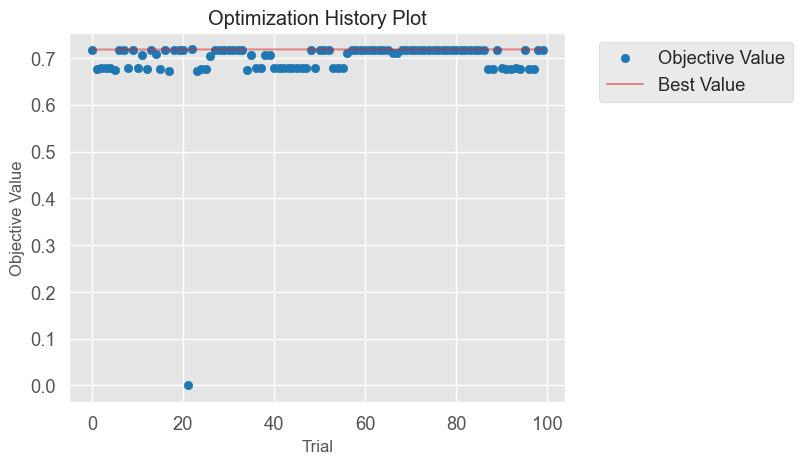

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study_lr)

In [ ]:
# Printing the best parameter outcomes
params_lr = study_lr.best_params
print(params_lr)

{'solver_penalty': ('lbfgs', 'l2'), 'C': 13.398418119492144, 'tol': 0.00029625850965732907, 'verbose': 0}


In [ ]:
# Listing the best parameters for modeling
final_params_lr = study_lr.best_trial.params.copy()

In [ ]:
# Separating solver and penalty
solver, penalty = final_params_lr.pop('solver_penalty')

# Add them separately
final_params_lr['solver'] = solver
final_params_lr['penalty'] = penalty

In [ ]:
# Instantiating the classifier 
model_lr_tuned = LogisticRegression(**final_params_lr, random_state=123)

# Fitting the model
model_lr_tuned.fit(X_train_PSO_GA_full, y_train_full)

LogisticRegression(C=13.398418119492144, random_state=123,
                   tol=0.00029625850965732907)

In [ ]:
# Making predictions (test set)
y_pred_lr_tuned = model_lr_tuned.predict(X_test_PSO_GA)
y_proba_lr_tuned = model_lr_tuned.predict_proba(X_test_PSO_GA)
y_proba_lr_tuned_pos = y_proba_lr_tuned[:, 1]

In [ ]:
# Making predictions (train set)
y_pred_lr_tuned_train = model_lr_tuned.predict(X_train_PSO_GA_full)
y_proba_lr_tuned_train = model_lr_tuned.predict_proba(X_train_PSO_GA_full)
y_proba_lr_tuned_train_pos = y_proba_lr_tuned_train[:, 1]

#### Evaluating logistic regression

In [ ]:
# Evaluating the prediction performance (test set)
evaluate(y_test, y_pred_lr_tuned, y_proba_lr_tuned_pos, "logistic regression with PSO-GA feature selection (test set)")

Evaluation metrics for logistic regression with PSO-GA feature selection (test set):
Accuracy: 0.6242
Precision: 0.4003
Recall: 0.7935
F1 Score: 0.5321
AUC-ROC: 0.7367
Precision-Recall AUC: 0.4651


In [ ]:
# Evaluating the prediction performance (train set)
evaluate(y_train_full, y_pred_lr_tuned_train, y_proba_lr_tuned_train_pos, "logistic regression with PSO-GA feature selection (train set)")

Evaluation metrics for logistic regression with PSO-GA feature selection (train set):
Accuracy: 0.6796
Precision: 0.6491
Recall: 0.7817
F1 Score: 0.7093
AUC-ROC: 0.7309
Precision-Recall AUC: 0.6841


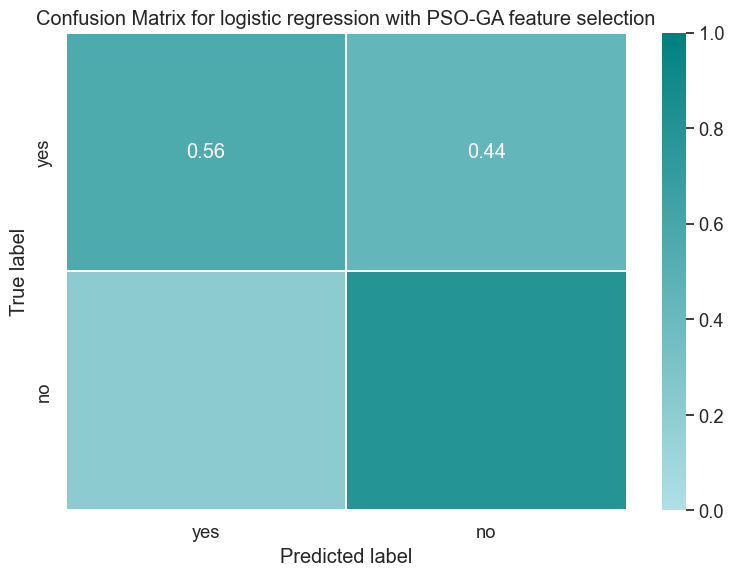

In [ ]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, y_pred_lr_tuned, "logistic regression with PSO-GA feature selection")

In [ ]:
# Printing the classification report
print(classification_report(y_test, y_pred_lr_tuned, target_names = ['yes', 'no']))

              precision    recall  f1-score   support

         yes       0.88      0.56      0.69      5440
          no       0.40      0.79      0.53      2005

    accuracy                           0.62      7445
   macro avg       0.64      0.68      0.61      7445
weighted avg       0.75      0.62      0.64      7445



### Random forest

In [ ]:
# Code inspired by:
# https://stackoverflow.com/questions/55591063/how-to-perform-smote-with-cross-validation-in-sklearn-in-python
# https://github.com/optuna/optuna
# https://medium.com/@taeefnajib/hyperparameter-tuning-using-optuna-c46d7b29a3e
# https://medium.com/@moussadoumbia_90919/mastering-hyperparameter-optimization-with-optuna-a-comprehensive-guide-0bd6b4b1bc67
# https://www.kaggle.com/code/mustafagerme/optimization-of-random-forest-model-using-optuna

# Define an objective function to be maximized using pre-defined train/val splits
def objective_rf(trial):
    # Defining the hyperparameters to be tuned
    n_estimators = trial.suggest_int("n_estimators", 100, 700, step=50)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    max_features = trial.suggest_categorical("max_features", ['log2', 'sqrt'])
    criterion = trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    
    # Defining model with trial hyperparameters
    params_rf = dict(max_depth=max_depth,
                     n_estimators=n_estimators,
                     max_features=max_features,
                     criterion=criterion,
                     min_samples_leaf=min_samples_leaf, 
                     min_samples_split=min_samples_split,
                     bootstrap=bootstrap
                     )
    model_rf = RandomForestClassifier(**params_rf, random_state=123, n_jobs=-1)
    
    # Fitting on training data
    model_rf.fit(X_train_PSO_GA, y_train)
    
    # Predicting and evaluating on validation data
    y_pred = model_rf.predict(X_val_PSO_GA)
    f1 = f1_score(y_val, y_pred, average='binary')
    
    return float(f1)

# Running Optuna study
optuna.logging.set_verbosity(optuna.logging.DEBUG)
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=100, n_jobs=-1, timeout=600)

# Printing results
print('Number of finished trials:', len(study_rf.trials))
print('Best parameters:', study_rf.best_trial.params)
print('Best F1 score:', study_rf.best_value)

[I 2025-05-16 21:24:05,953] A new study created in memory with name: no-name-671eee5c-d3a3-496f-802f-2122f45adb9e
[I 2025-05-16 21:24:28,617] Trial 6 finished with value: 0.7886972310485701 and parameters: {'n_estimators': 100, 'max_depth': 12, 'max_features': 'log2', 'criterion': 'entropy', 'min_samples_split': 9, 'min_samples_leaf': 9, 'bootstrap': False}. Best is trial 6 with value: 0.7886972310485701.
[I 2025-05-16 21:24:46,718] Trial 3 finished with value: 0.7862857142857143 and parameters: {'n_estimators': 200, 'max_depth': 20, 'max_features': 'sqrt', 'criterion': 'log_loss', 'min_samples_split': 8, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 6 with value: 0.7886972310485701.
[I 2025-05-16 21:24:55,989] Trial 0 finished with value: 0.7865888545600183 and parameters: {'n_estimators': 200, 'max_depth': 19, 'max_features': 'log2', 'criterion': 'log_loss', 'min_samples_split': 7, 'min_samples_leaf': 8, 'bootstrap': False}. Best is trial 6 with value: 0.7886972310485701.


In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

In [ ]:
# Printing the best parameter outcomes
params_rf = study_rf.best_params
print(params_rf)

In [ ]:
# Listing the best parameters for modeling
final_params_rf = dict(max_depth=params_rf['max_depth'],
                       n_estimators=params_rf['n_estimators'],
                       max_features=params_rf['max_features'],
                       criterion=params_rf['criterion'],
                       min_samples_leaf=params_rf['min_samples_leaf'],
                       min_samples_split=params_rf['min_samples_split'],
                       bootstrap=params_rf['bootstrap']
                       )

In [ ]:
# Instantiating the classifier 
model_rf_tuned = RandomForestClassifier(**final_params_rf, random_state=123)

# Fitting the model
model_rf_tuned.fit(X_train_PSO_GA_full, y_train_full)

In [ ]:
# Making predictions (test set)
y_pred_rf = model_rf_tuned.predict(X_test_PSO_GA)
y_proba_rf = model_rf_tuned.predict_proba(X_test_PSO_GA)
y_proba_rf_pos = y_proba_rf[:, 1]

In [ ]:
# Making predictions (train set)
y_pred_rf_train = model_rf_tuned.predict(X_train_PSO_GA_full)
y_proba_rf_train = model_rf_tuned.predict_proba(X_train_PSO_GA_full)
y_proba_rf_train_pos = y_proba_rf_train[:, 1]

#### Evaluating random forest

In [ ]:
# Evaluating the prediction performance (test set)
evaluate(y_test, y_pred_rf, y_proba_rf_pos, "random forest with PSO-GA feature selection")

In [ ]:
# Evaluating the prediction performance (train set)
evaluate(y_train_full, y_pred_rf_train, y_proba_rf_train_pos, "random forest with PSO-GA feature selection (train set)")

In [ ]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, y_pred_rf, "random forest with PSO-GA feature selection")

In [ ]:
# Printing the classification report
print(classification_report(y_test, y_pred_rf))

### XGBoost

In [ ]:
# Code inspired by:
# https://stackoverflow.com/questions/55591063/how-to-perform-smote-with-cross-validation-in-sklearn-in-python
# https://github.com/optuna/optuna
# https://medium.com/@taeefnajib/hyperparameter-tuning-using-optuna-c46d7b29a3e
# https://medium.com/@moussadoumbia_90919/mastering-hyperparameter-optimization-with-optuna-a-comprehensive-guide-0bd6b4b1bc67
# https://www.kaggle.com/code/cahyaalkahfi/xgboost-model-tuning-using-optuna

# Defining an objective function to be maximized using pre-defined train/val splits
def objective_xgb(trial):
    # Defining the hyperparameters to be tuned
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_float('gamma', 0, 5)
    
    # Defining model with trial hyperparameters
    params_xgb = dict(n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree, 
                     min_child_weight=min_child_weight,
                     gamma=gamma
                     )
    model_xgb = XGBClassifier(**params_xgb, random_state=123, n_jobs=-1)
    
    # Fitting on training data
    model_xgb.fit(X_train_PSO_GA, y_train)
    
    # Predicting and evaluating on validation data
    y_pred = model_xgb.predict(X_val_PSO_GA)
    f1 = f1_score(y_val, y_pred, average='binary')
    
    return float(f1)

# Running Optuna study
optuna.logging.set_verbosity(optuna.logging.DEBUG)
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100, n_jobs=-1, timeout=600)

# Printing results
print('Number of finished trials:', len(study_xgb.trials))
print('Best parameters:', study_xgb.best_trial.params)
print('Best F1 score:', study_xgb.best_value)

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study_xgb)

In [ ]:
# Printing the best parameter outcomes
params_xgb = study_xgb.best_params
print(params_xgb)

In [ ]:
# Listing the best parameters for modeling
final_params_xgb = dict(max_depth=params_xgb['max_depth'],
                       learning_rate=params_xgb['learning_rate'],
                       n_estimators=params_xgb['n_estimators'],
                       subsample=params_xgb['subsample'],
                       colsample_bytree=params_xgb['colsample_bytree'],
                       min_child_weight=params_xgb['min_child_weight'],
                       gamma=params_xgb['gamma']
                       )

In [ ]:
# Instantiating the classifier 
model_xgb_tuned = XGBClassifier(**final_params_xgb, random_state=123)

# Fitting the model
model_xgb_tuned.fit(X_train_PSO_GA_full, y_train_full)

In [ ]:
# Making predictions (test set)
y_pred_xgb = model_xgb_tuned.predict(X_test_PSO_GA)
y_proba_xgb = model_xgb_tuned.predict_proba(X_test_PSO_GA)
y_proba_xgb_pos = y_proba_xgb[:, 1]

In [ ]:
# Making predictions (train set)
y_pred_xgb_train = model_xgb_tuned.predict(X_train_PSO_GA_full)
y_proba_xgb_train = model_xgb_tuned.predict_proba(X_train_PSO_GA_full)
y_proba_xgb_train_pos = y_proba_xgb_train[:, 1]

#### Evaluating XGBoost

In [ ]:
# Evaluating the prediction performance (test set)
evaluate(y_test, y_pred_xgb, y_proba_xgb_pos, "XGBoost with PSO-GA feature selection")

In [ ]:
# Evaluating the prediction performance (train set)
evaluate(y_train_full, y_pred_xgb_train, y_proba_xgb_train_pos, "XGBoost with PSO-GA feature selection (train set)")

In [ ]:
# Plotting the confusion matrix
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost with PSO-GA feature selection")

In [ ]:
# Printing the classification report
print(classification_report(y_test, y_pred_xgb))

## SHAP

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
feature_names = X_train_PSO_GA_full.columns.tolist()

In [ ]:
X_train_PSO_GA_full = X_train_PSO_GA_full.values.astype(float)

In [ ]:
X_train_PSO_GA_full = pd.DataFrame(X_train_PSO_GA_full, columns=feature_names)

### Baseline logistic regression SHAP analysis

In [ ]:
# Code inspired by:
# https://github.com/jw-uvt/master-s-thesis-DS-S
# Calculating SHAP values
explainer_baseline_LR = shap.LinearExplainer(model_lr, X_train_PSO_GA_full)
shap_values_baseline_LR = explainer_baseline_LR(X_train_PSO_GA_full)

In [ ]:
# Confirming shapes match before plotting
print("shap_values_LR shape:", shap_values_baseline_LR.shape)
print("X_train_PSO_GA_full shape:", X_train_PSO_GA_full.shape)

In [ ]:
# Ensuring that column names are included
shap_values_baseline_LR_expl = shap.Explanation(
    values=shap_values_baseline_LR,
    base_values=explainer_baseline_LR.expected_value,
    data=X_train_PSO_GA_full,
    feature_names=X_train_PSO_GA_full.columns.tolist()
)

In [ ]:
shap.plots.bar(shap_values_baseline_LR_expl)

In [ ]:
shap_values_baseline_LR_expl = shap_values_baseline_LR_expl.values.astype(float)
shap.summary_plot(shap_values_baseline_LR_expl, X_train_PSO_GA_full, max_display=20)

In [ ]:
# Calculating absolute SHAP values
abs_shap_values_LR = np.abs(shap_values_baseline_LR_expl)

# Summing for each feature across all samples
overall_shap_values_baseline_LR = np.sum(shap_values_baseline_LR_expl, axis=0)

# Sorting features based on their absolute SHAP values
sorted_features_indices_baseline_LR = np.argsort(overall_shap_values_baseline_LR)[::-1]
sorted_features_baseline_LR = [feature_names[i] for i in sorted_features_indices_baseline_LR]

for feature_LR, shap_value_LR in zip(sorted_features_baseline_LR, overall_shap_values_baseline_LR[sorted_features_indices_baseline_LR]):
    print(f"Feature: {feature_LR}, Overall SHAP Value: {shap_value_LR}")

In [ ]:
total_features_baseline_LR = len(sorted_features_baseline_LR)

# Counting number of features with overall SHAP value of 0
zero_shap_count_baseline_LR = np.count_nonzero(overall_shap_values_baseline_LR == 0)

print(f"Total number of features: {total_features_baseline_LR}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count_baseline_LR}")

### Logistic regression SHAP analysis

In [ ]:
# Calculating SHAP values
explainer_LR = shap.LinearExplainer(model_lr_tuned, X_train_PSO_GA_full)
shap_values_LR = explainer_LR(X_train_PSO_GA_full)

In [ ]:
# Confirming shapes match before plotting
print("shap_values_LR shape:", shap_values_LR.shape)
print("X_train_PSO_GA_full shape:", X_train_PSO_GA_full.shape)

In [ ]:
# Ensuring that column names are included
shap_values_LR_expl = shap.Explanation(
    values=shap_values_LR,
    base_values=explainer_LR.expected_value,
    data=X_train_PSO_GA_full,
    feature_names=X_train_PSO_GA_full.columns.tolist()
)

In [ ]:
shap.plots.bar(shap_values_LR_expl)

In [ ]:
shap_values_LR_expl = shap_values_LR_expl.values.astype(float)
shap.summary_plot(shap_values_LR_expl, X_train_PSO_GA_full, max_display=20)

In [ ]:
# Calculating absolute SHAP values
abs_shap_values_LR = np.abs(shap_values_LR_expl)

# Summing for each feature across all samples
overall_shap_values_LR = np.sum(shap_values_LR_expl, axis=0)

# Sorting features based on their absolute SHAP values
sorted_features_indices_LR = np.argsort(overall_shap_values_LR)[::-1]
sorted_features_LR = [feature_names[i] for i in sorted_features_indices_LR]

for feature_LR, shap_value_LR in zip(sorted_features_LR, overall_shap_values_LR[sorted_features_indices_LR]):
    print(f"Feature: {feature_LR}, Overall SHAP Value: {shap_value_LR}")

In [ ]:
total_features_LR = len(sorted_features_LR)

# Counting number of features with overall SHAP value of 0
zero_shap_count_LR = np.count_nonzero(overall_shap_values_LR == 0)

print(f"Total number of features: {total_features_LR}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count_LR}")

### Random forest SHAP analysis

In [ ]:
# Calculating SHAP values
explainer_RF = shap.TreeExplainer(model_rf_tuned, X_train_PSO_GA_full)
shap_values_RF = explainer_RF(X_train_PSO_GA_full, approximate=True)

#### Class 1 (Tax Avoidance)

In [ ]:
# Ensuring that column names are included
shap_values_RF_class_1 = shap_values_RF[:, :, 1]
shap_values_RF_expl_1 = shap.Explanation(
    values=shap_values_RF_class_1,
    base_values=explainer_RF.expected_value[1],
    data=X_train_PSO_GA_full,
    feature_names=X_train_PSO_GA_full.columns.tolist()
)

In [ ]:
shap.plots.bar(shap_values_RF_expl_1)

In [ ]:
shap_values_RF_array_1 = shap_values_RF_class_1.values.astype(float)
shap.summary_plot(shap_values_RF_array_1, X_train_PSO_GA_full, max_display=20)

In [ ]:
# Absolute SHAP values
abs_shap_values_RF_1 = np.abs(shap_values_RF_array_1)

# Overall importance per feature
overall_shap_values_RF_1 = np.sum(abs_shap_values_RF_1, axis=0)

# Sort features by importance
feature_names = X_train_PSO_GA_full.columns.tolist()
sorted_indices_RF_1 = np.argsort(overall_shap_values_RF_1)[::-1]
sorted_features_RF_1 = [feature_names[i] for i in sorted_indices_RF_1]

# Display sorted feature importance
for feature, value in zip(sorted_features_RF_1, overall_shap_values_RF_1[sorted_indices_RF_1]):
    print(f"Feature: {feature}, Overall SHAP Value: {value}")

# Summary stats
total_features_RF_1 = len(sorted_features_RF_1)
zero_shap_count_RF_1 = np.count_nonzero(overall_shap_values_RF_1 == 0)

print(f"Total number of features: {total_features_RF_1}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count_RF_1}")

#### Class 0: No Tax Avoidance

In [ ]:
# Ensuring that column names are included
shap_values_RF_class_0 = shap_values_RF[:, :, 0]
shap_values_RF_expl_0 = shap.Explanation(
    values=shap_values_RF_class_0,
    base_values=explainer_RF.expected_value[0],
    data=X_train_PSO_GA_full.values,
    feature_names=X_train_PSO_GA_full.columns.tolist()
)

In [ ]:
shap.plots.bar(shap_values_RF_expl_0)

In [ ]:
shap_values_RF_array_0 = shap_values_RF_class_0.values.astype(float)
shap.summary_plot(shap_values_RF_array_0, X_train_PSO_GA_full, max_display=20)

In [ ]:
# Absolute SHAP values
abs_shap_values_RF_0 = np.abs(shap_values_RF_array_0)

# Overall importance per feature
overall_shap_values_RF_0 = np.sum(abs_shap_values_RF_0, axis=0)

# Sort features by importance
feature_names = X_train_PSO_GA_full.columns.tolist()
sorted_indices_RF_0 = np.argsort(overall_shap_values_RF_0)[::-1]
sorted_features_RF_0 = [feature_names[i] for i in sorted_indices_RF_0]

# Display sorted feature importance
for feature, value in zip(sorted_features_RF_0, overall_shap_values_RF_0[sorted_indices_RF_0]):
    print(f"Feature: {feature}, Overall SHAP Value: {value}")

# Summary stats
total_features_RF_0 = len(sorted_features_RF_0)
zero_shap_count_RF_0 = np.count_nonzero(overall_shap_values_RF_0 == 0)

print(f"Total number of features: {total_features_RF_0}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count_RF_0}")

### XGBoost SHAP analysis

In [ ]:
# Calculating SHAP values
explainer_XGB = shap.TreeExplainer(model_xgb_tuned, X_train_PSO_GA_full)
shap_values_XGB = explainer_XGB(X_train_PSO_GA_full)

In [ ]:
# Confirm shapes match before plotting
print("shap_values_XGB shape:", shap_values_XGB.shape)
print("X_train_PSO_GA_full shape:", X_train_PSO_GA_full.shape)

In [ ]:
# Ensure that column names are included
shap_values_XGB_expl = shap.Explanation(
    values=shap_values_XGB,
    base_values=explainer_XGB.expected_value,
    data=X_train_PSO_GA_full,
    feature_names=X_train_PSO_GA_full.columns.tolist()
)

In [ ]:
shap.plots.bar(shap_values_XGB_expl)

In [ ]:
shap_values_XGB_expl = shap_values_XGB_expl.values.astype(float)
shap.summary_plot(shap_values_XGB_expl, X_train_PSO_GA_full, max_display=20)

In [ ]:
# Calculating absolute SHAP values
abs_shap_values_XGB = np.abs(shap_values_XGB_expl)

# Summing for each feature across all samples
overall_shap_values_XGB = np.sum(shap_values_XGB_expl, axis=0)

# Sorting features based on their absolute SHAP values
sorted_features_indices_XGB = np.argsort(overall_shap_values_XGB)[::-1]
sorted_features_XGB = [feature_names[i] for i in sorted_features_indices_XGB]

for feature_XGB, shap_value_XGB in zip(sorted_features_XGB, overall_shap_values_XGB[sorted_features_indices_XGB]):
    print(f"Feature: {feature_XGB}, Overall SHAP Value: {shap_value_XGB}")

In [ ]:
total_features_XGB = len(sorted_features_XGB)

# Counting number of features with overall SHAP value of 0
zero_shap_count_XGB = np.count_nonzero(overall_shap_values_XGB == 0)

print(f"Total number of features: {total_features_XGB}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count_XGB}")